In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 도시 딕셔너리
city_dict = {
    '서울특별시': 'seoul',
    '경기도': 'gyeonggi',
    '인천광역시': 'incheon',
    '부산광역시': 'busan',
    '대구광역시': 'daegu',
    '광주광역시': 'gwangju',
    '대전광역시': 'daejeon',
    '울산광역시': 'ulsan'
}

# 수도권 도시 리스트
capital_region_cities = ['seoul', 'gyeonggi', 'incheon']

In [ ]:
def merge_per_city(city_name: str) -> pd.DataFrame:
    """
    주어진 도시의 2010~2019 CSV 파일을 읽어와서 하나의 DataFrame으로 합칩니다.
    불필요한 컬럼을 삭제하고 파생 컬럼을 추가합니다.
    (권역, 계약월, 계약계절, 면적구간, 평당가, 건축연수, 신축여부)
    """
    merged_data = {}
    sep = 'c' if city_name in capital_region_cities else 'p'

    for year in range(2010, 2020):
        file_path = f'./raw_data/{sep}_{city_name}_{year}.csv'
        merged_data[year] = pd.read_csv(file_path, encoding='EUC-KR', header=15)

    # 권역 컬럼 추가 후 합치기
    df_list = []
    for year, df in merged_data.items():
        df = df.copy()
        df_list.append(df)

    df_merged = pd.concat(df_list, ignore_index=True)

    # 삭제할 컬럼명 리스트
    all_dash_cols = (df_merged == '-').sum() == df_merged.shape[0]
    cols_to_drop = list(all_dash_cols[all_dash_cols].index)
    for col in ['NO', '도로명']:
        if col in df_merged.columns:
            cols_to_drop.append(col)

    # 컬럼 삭제
    df_merged = df_merged.drop(columns=cols_to_drop)

    # 권역 컬럼 추가
    region_flag = '수도권' if sep == 'c' else '지방'
    df_merged['권역'] = region_flag

    # 계약년도 추출
    df_merged['계약년도'] = df_merged['계약년월'] // 100

    # 계약월 추출
    df_merged['계약월'] = df_merged['계약년월'] % 100

    # 거래금액 처리
    df_merged['거래금액(만원)'] = (df_merged['거래금액(만원)'].astype(str).str.replace(',', '', regex=False).astype(int))

    # 평당가 컬럼 추가
    df_merged['price_per_m2'] = (df_merged['거래금액(만원)'] / df_merged['전용면적(㎡)']).round(1)

    # 건축연수 컬럼 추가
    df_merged['building_age'] = df_merged['계약년도'] - df_merged['건축년도']

    # 면적 구간(area_bin) 컬럼 추가
    def categorize_area(area):
        if area <= 60:
            return '소형'
        elif area <= 85:
            return '중소형'
        elif area <= 135:
            return '중대형'
        elif area > 135:
            return '대형'
   
    df_merged['area_bin'] = df_merged['전용면적(㎡)'].apply(categorize_area)

    # 신축 여부 컬럼 추가
    df_merged['is_new_building'] = df_merged['building_age'] <= 5

    # 계약계절 컬럼 추가
    def season(month):
        if month in [3, 4, 5]:
            return '봄'
        elif month in [6, 7, 8]:
            return '여름'
        elif month in [9, 10, 11]:
            return '가을'
        elif month in [12, 1, 2]:
            return '겨울'

    df_merged['contract_season'] = df_merged['계약월'].apply(season)

    cols_order = ['권역', '시군구', '번지', '본번',  '부번',  '단지명', '계약년월', '계약년도', '계약월', '계약일', 'contract_season',  'area_bin', '전용면적(㎡)', '거래금액(만원)', 'price_per_m2',\
                  '층', '건축년도', 'building_age', 'is_new_building']
    df_merged = df_merged[[col for col in cols_order if col in df_merged.columns] + 
                        [col for col in df_merged.columns if col not in cols_order]]

    return df_merged

# 도시별 df를 모두 생성해서 딕셔너리에 저장
cities_df = {f'{eng}_raw': merge_per_city(eng) for eng in city_dict.values()}

In [ ]:
from da_utils import profile, outliers, patterns

# 각 도시의 실거래가 데이터 프로파일링
for city_ko, city_en in city_dict.items():
    print(f"# {city_ko} 실거래가 데이터 (2010~2019)")
    profile.get_data_profile(cities_df[f"{city_en}_raw"])
    print("\n")

In [5]:
import sys  # 물줄기(호스) 다루는 도구
from io import StringIO  # 빈 통(문자열 모으기) 도구

html_content = ""  # 빈 문자열: 마치 빈 앨범처럼, 여기에 텍스트와 표 쌓을게요

for city_ko, city_en in city_dict.items():
    # 헤더 추가 (이건 print 안 하고 직접 HTML에 넣어요 – 비유: 제목 스티커 붙이기)
    html_content += f"<h1># {city_ko} 실거래가 데이터 (2010~2019)</h1>"
    
    # print 캡처 시작: 기존 호스 저장하고, 새 통으로 바꿈 (녹음기 켜기)
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    
    # 함수 호출: 여기서 함수가 print(텍스트) 하면 통에 모여요
    result = profile.get_data_profile(cities_df[f"{city_en}_raw"])
    
    # 캡처 끝: 호스 원래대로 복구하고, 통 내용 꺼내기 (녹음기 끄고 듣기)
    sys.stdout = old_stdout
    captured_text = mystdout.getvalue()
    
    # 캡처된 텍스트를 HTML에 추가 ( <pre>로 감싸서 줄바꿈 그대로 보이게 – 비유: 녹음된 소리를 스크립트로 적기)
    if captured_text:  # 텍스트가 있으면
        html_content += "<pre>" + captured_text + "</pre>"
    
    # 결과가 데이터프레임(표)인지 확인하고 HTML로 변환 (이전처럼 표 사진 찍기)
    if isinstance(result, pd.DataFrame):
        html_content += result.to_html()
    elif hasattr(result, 'to_html'):  # 프로파일링 보고서라면
        html_content += result.to_html()
    else:
        html_content += "<p>결과가 표나 보고서가 아니에요. 함수를 확인하세요.</p>"
    
    html_content += "<br><br>"  # 빈 줄 추가 (HTML에서 공간 주기)

# 전체를 HTML 파일로 저장 (앨범 완성해서 파일로 보관)
with open('data_profile_output.html', 'w', encoding='utf-8') as f:
    f.write('<html><body>')
    f.write(html_content)
    f.write('</body></html>')

,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,567.411,517.795,1.00,4955.00,2.645,15.902,2.848,0.192
1,부번,5.484,42.276,0.00,2837.00,28.899,1280.292,14.975,0.042
2,계약년월,201516.902,256.471,201001.00,201912.00,-0.329,-0.781,0.000,0.015
3,계약년도,2015.104,2.563,2010.00,2019.00,-0.332,-0.783,0.000,0.001
4,계약월,6.531,3.346,1.00,12.00,-0.032,-1.166,0.000,0.002
5,계약일,15.851,8.733,1.00,31.00,-0.008,-1.175,0.000,0.004
6,전용면적(㎡),78.357,29.525,10.02,424.32,1.202,3.600,8.537,1.682
7,거래금액(만원),54835.544,40216.033,350.00,1053000.00,3.343,21.584,6.782,1.449
8,price_per_m2,693.985,364.999,6.10,6969.60,2.371,9.488,5.711,2.865
9,층,8.929,6.022,-4.00,69.00,1.151,2.715,1.019,0.009


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,744.150,610.885,0.00,7346.00,3.975,31.931,2.694,0.113
1,부번,2.768,30.543,0.00,1397.00,39.837,1780.377,14.434,0.009
2,계약년월,201488.531,268.499,201001.00,201912.00,-0.152,-1.002,0.000,0.008
3,계약년도,2014.819,2.683,2010.00,2019.00,-0.155,-1.004,0.000,0.001
4,계약월,6.608,3.387,1.00,12.00,-0.061,-1.211,0.000,0.001
5,계약일,15.760,8.730,1.00,31.00,0.008,-1.173,0.000,0.002
6,전용면적(㎡),77.647,27.046,10.44,273.88,1.091,2.164,8.596,0.771
7,거래금액(만원),28927.432,16472.251,380.00,450000.00,2.078,8.851,4.368,1.251
8,price_per_m2,372.627,162.445,3.20,3217.80,2.028,8.482,4.021,0.913
9,층,9.116,5.920,-2.00,66.00,0.897,1.851,0.641,0.005


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,526.213,468.798,0.00,2924.000,1.717,4.783,4.241,0.252
1,부번,11.727,49.705,0.00,661.000,7.326,60.144,11.870,0.043
2,계약년월,201501.946,258.377,201001.00,201912.000,-0.184,-0.853,0.000,0.036
3,계약년도,2014.954,2.583,2010.00,2019.000,-0.186,-0.854,0.000,0.003
4,계약월,6.578,3.353,1.00,12.000,-0.038,-1.209,0.000,0.004
5,계약일,15.787,8.766,1.00,31.000,0.002,-1.178,0.000,0.009
6,전용면적(㎡),74.794,26.342,10.89,295.707,0.849,1.368,6.626,1.371
7,거래금액(만원),23704.602,12482.517,2500.00,365000.000,2.114,14.637,4.319,2.145
8,price_per_m2,312.058,94.590,53.70,1234.300,1.058,2.156,2.385,1.882
9,층,9.289,6.904,-1.00,63.000,1.416,3.643,2.092,0.019


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,805.986,668.039,1.00,7375.000,1.247,2.115,1.996,0.315
1,부번,11.147,64.600,0.00,2172.000,17.139,358.081,13.324,0.044
2,계약년월,201430.255,277.051,201001.00,201912.000,0.011,-1.043,0.000,0.027
3,계약년도,2014.237,2.768,2010.00,2019.000,0.009,-1.047,0.000,0.002
4,계약월,6.592,3.438,1.00,12.000,-0.015,-1.273,0.000,0.003
5,계약일,15.797,8.729,1.00,31.000,-0.004,-1.171,0.000,0.007
6,전용면적(㎡),78.298,30.378,9.26,295.434,1.169,2.189,10.995,2.102
7,거래금액(만원),23767.100,15542.794,729.00,414340.000,3.437,35.287,4.859,2.564
8,price_per_m2,296.618,118.241,8.60,1861.400,1.472,5.079,3.244,1.838
9,층,10.290,7.652,-2.00,80.000,1.459,4.358,1.513,0.018


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,756.159,555.282,1.00,3060.0,0.913,0.935,1.273,0.302
1,부번,4.217,23.989,0.00,505.0,12.997,209.804,17.380,0.038
2,계약년월,201428.349,288.318,201001.00,201912.0,0.188,-1.226,0.000,0.036
3,계약년도,2014.218,2.882,2010.00,2019.0,0.187,-1.226,0.000,0.003
4,계약월,6.543,3.415,1.00,12.0,-0.015,-1.240,0.000,0.004
5,계약일,15.811,8.791,1.00,31.0,-0.002,-1.185,0.000,0.009
6,전용면적(㎡),81.597,29.393,11.88,296.6,1.148,1.833,12.359,1.163
7,거래금액(만원),23521.343,14568.891,1000.00,345000.0,2.345,12.275,4.534,2.497
8,price_per_m2,280.555,113.160,22.60,1495.2,1.561,5.168,3.502,2.292
9,층,9.193,6.435,-1.00,56.0,1.113,2.194,1.357,0.017


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,759.468,417.542,1.000,3102.00,0.592,3.019,0.435,0.291
1,부번,3.092,9.326,0.000,305.00,8.046,100.311,12.858,0.025
2,계약년월,201438.558,290.909,201001.000,201912.00,0.040,-1.253,0.000,0.050
3,계약년도,2014.321,2.908,2010.000,2019.00,0.039,-1.254,0.000,0.004
4,계약월,6.503,3.473,1.000,12.00,0.003,-1.269,0.000,0.005
5,계약일,15.787,8.732,1.000,31.00,-0.004,-1.173,0.000,0.013
6,전용면적(㎡),75.765,25.611,14.121,283.11,1.101,2.197,7.564,0.871
7,거래금액(만원),17059.194,10388.851,1200.000,185000.00,2.098,9.288,4.191,2.175
8,price_per_m2,219.059,88.153,12.100,1306.30,1.442,4.617,3.019,2.362
9,층,8.413,5.407,-1.000,35.00,0.542,-0.419,0.250,0.015


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,519.491,419.626,1.000,1985.00,1.010,0.581,1.977,0.255
1,부번,3.355,19.907,0.000,1113.00,16.726,507.003,16.400,0.029
2,계약년월,201468.912,296.749,201001.000,201912.00,-0.065,-1.238,0.000,0.056
3,계약년도,2014.622,2.965,2010.000,2019.00,-0.067,-1.239,0.000,0.005
4,계약월,6.693,3.495,1.000,12.00,-0.086,-1.276,0.000,0.006
5,계약일,15.728,8.719,1.000,31.00,0.007,-1.170,0.000,0.015
6,전용면적(㎡),77.021,26.380,12.005,260.95,0.623,1.357,8.578,1.273
7,거래금액(만원),20673.999,11664.407,1250.000,250000.00,1.950,9.448,3.171,2.076
8,price_per_m2,262.257,93.192,29.400,1281.00,1.408,4.585,2.677,2.910
9,층,8.769,5.842,-1.000,50.00,1.099,2.602,1.218,0.024


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,본번,633.068,462.214,1.00,1911.00,0.935,0.163,2.543,0.499
1,부번,5.682,16.578,0.00,426.00,10.374,189.307,13.055,0.036
2,계약년월,201400.561,272.974,201001.00,201912.00,0.291,-0.936,0.000,0.070
3,계약년도,2013.940,2.728,2010.00,2019.00,0.288,-0.940,0.000,0.006
4,계약월,6.532,3.439,1.00,12.00,0.016,-1.258,0.000,0.007
5,계약일,15.922,8.774,1.00,31.00,-0.020,-1.178,0.000,0.018
6,전용면적(㎡),77.706,25.556,16.54,296.94,1.321,2.667,8.590,1.870
7,거래금액(만원),21297.300,11828.332,1700.00,140231.00,1.200,1.979,2.434,2.823
8,price_per_m2,265.009,95.239,36.60,894.70,0.584,0.573,1.009,3.148
9,층,9.025,6.307,-1.00,54.00,1.190,2.410,1.366,0.032


### 프로파일링 결과 바탕으로 한 **데이터 전처리** 방안

1. 건축연수 음수값 조회 및 정정
- 거래금액, price_per_m2 로그 변환


In [6]:
# 1. 건축연수 음수값 조회 및 정정
for city_ko, city_en in city_dict.items():
    mask = cities_df[f'{city_en}_raw']['building_age'] < 0
    print(f"=== {city_ko} 건축연수 음수값 조회 ===")
    print(cities_df[f"{city_en}_raw"][mask].groupby('building_age').size())

=== 서울특별시 건축연수 음수값 조회 ===
building_age
-1    37
dtype: int64
=== 경기도 건축연수 음수값 조회 ===
building_age
-1    71
dtype: int64
=== 인천광역시 건축연수 음수값 조회 ===
building_age
-1    3
dtype: int64
=== 부산광역시 건축연수 음수값 조회 ===
building_age
-1    4
dtype: int64
=== 대구광역시 건축연수 음수값 조회 ===
building_age
-1    4
dtype: int64
=== 광주광역시 건축연수 음수값 조회 ===
building_age
-1    3
dtype: int64
=== 대전광역시 건축연수 음수값 조회 ===
building_age
-1    1
dtype: int64
=== 울산광역시 건축연수 음수값 조회 ===
Series([], dtype: int64)


In [7]:
"""
건축연수가 -1인 경우는 아파트 사용승인일 전의 분양권 매매로 판단하여 건축연수 0으로 수정
"""

for city_ko, city_en in city_dict.items():
    cities_df[f"{city_en}_raw"].loc[cities_df[f"{city_en}_raw"]['building_age'] == -1, 'building_age'] = 0

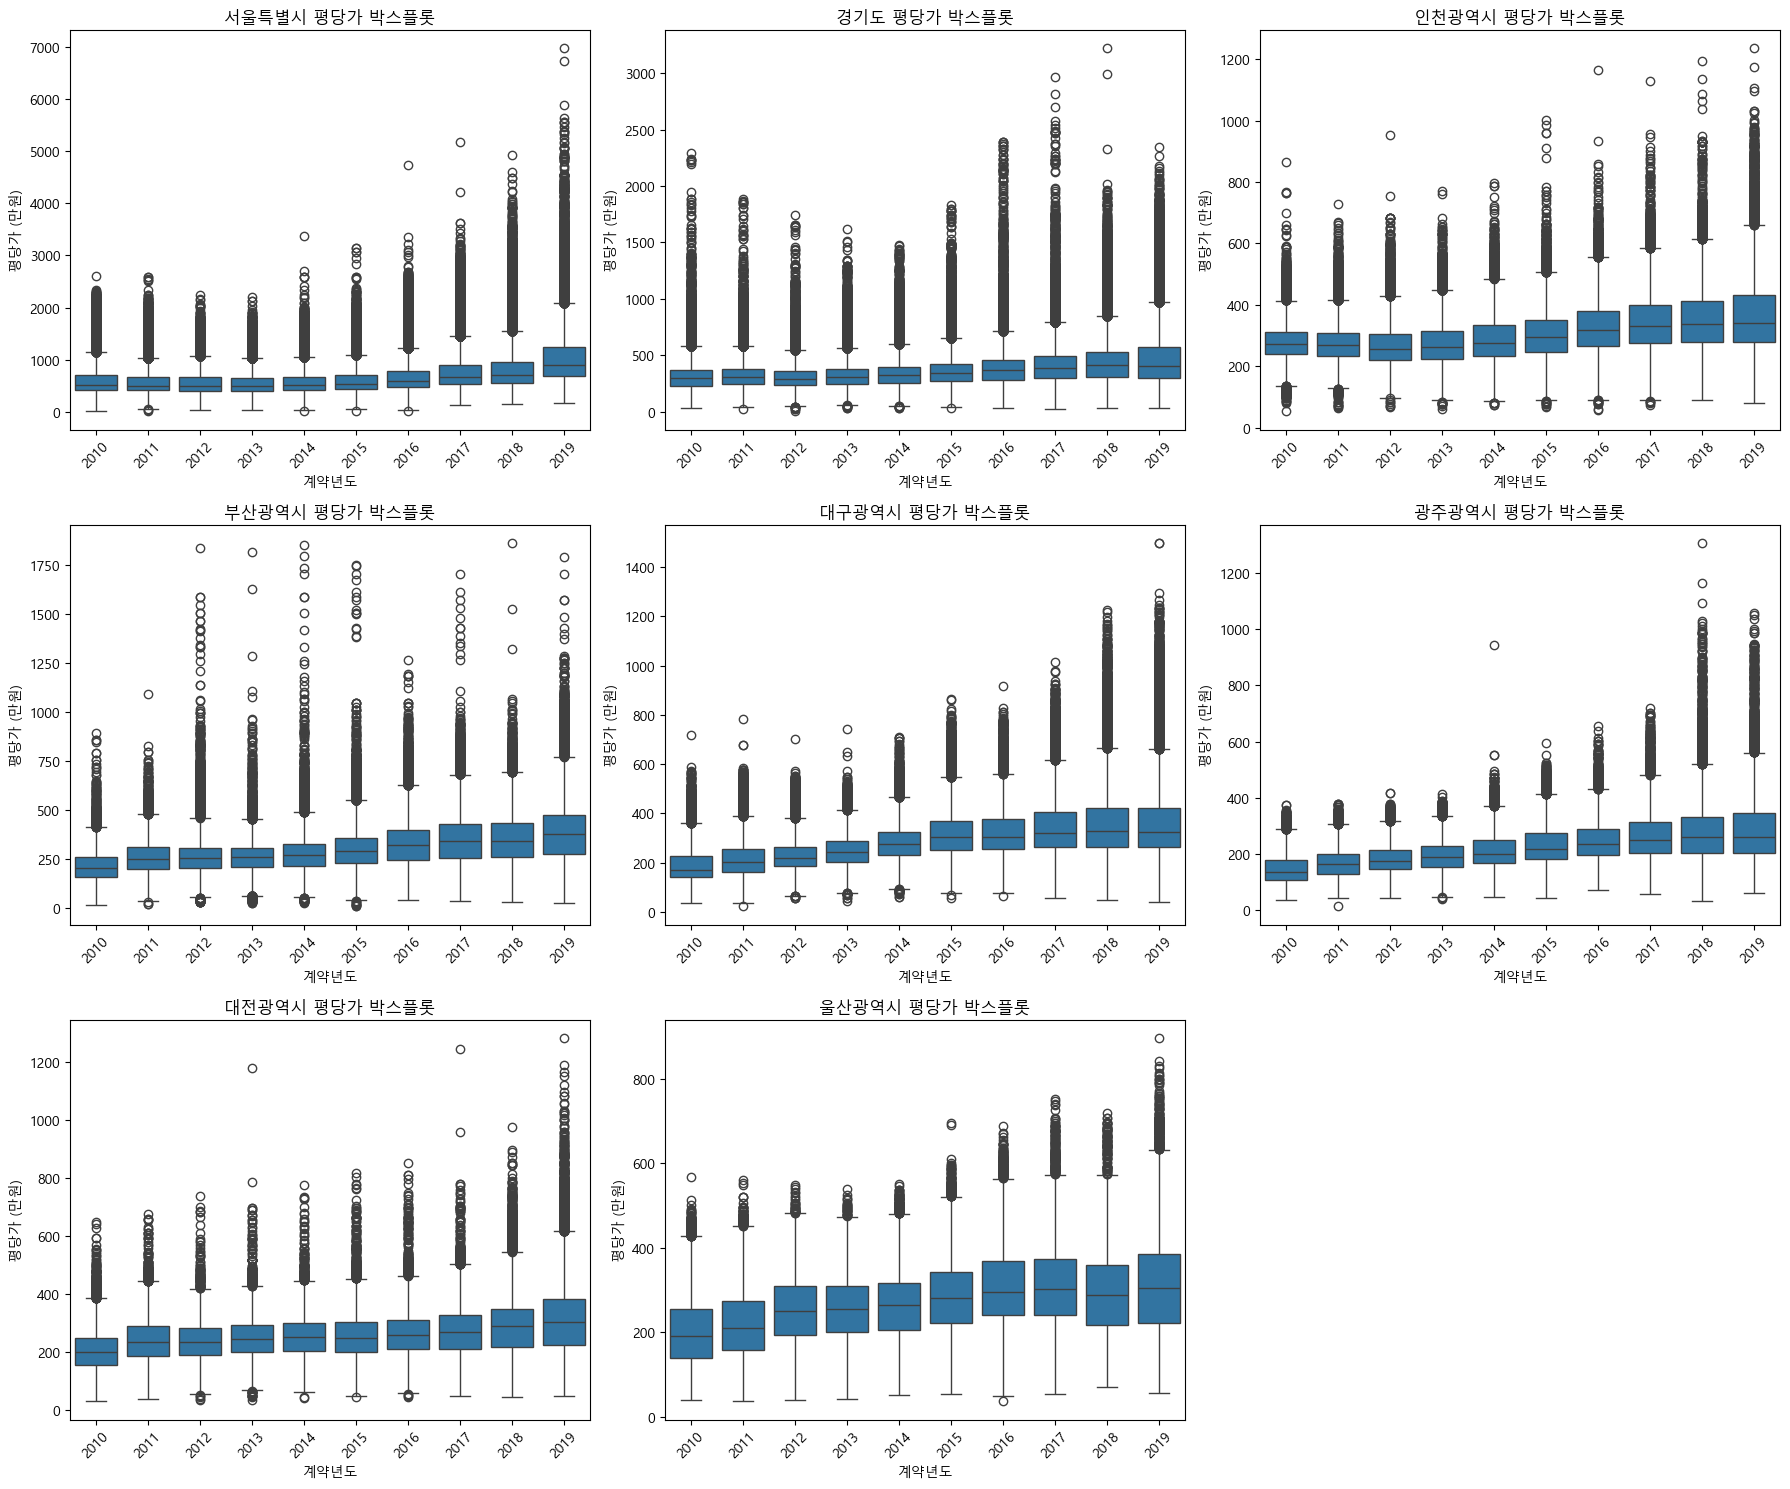

In [8]:
# 2.

# 평당가 박스플롯

# 서브플롯 행/열 계산
n_cities = len(city_dict)
n_cols = 3  # 한 행에 3개 도시씩 표시
n_rows = (n_cities + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols*6, n_rows*5))

for i, (city_ko, city_en) in enumerate(city_dict.items()):
    df = cities_df[f'{city_en}_raw']
    
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x='계약년도', y='price_per_m2', data=df)

    plt.title(f"{city_ko} 평당가 박스플롯")
    plt.xticks(rotation=45)
    plt.ylabel("평당가 (만원)")
    plt.xlabel("계약년도")

plt.tight_layout()
plt.show()


In [ ]:
"""
'거래금액(만원)' 이상치 처리
1. 도시별/('시군구', '번지', '단지명', '계약년도) 그룹화
2. 거래량 많음 : 그룹화 기준으로 극단 이상샘플(상위 1% 초고가, 하위 1% 초저가) 윈저화 처리
3. 거래량 적음 : 그룹화 기준으로 극단 이상샘플(상위 1% 초고가, 하위 1% 초저가) 플래그

수도권과 지방 거래량 기준의 차이점
- 수도권: 단지별 거래량이 상대적으로 높음(대단지: 연간 50~200건도 많음)
        → 단지/연 30건 이상을 '많음' 기준으로 잡아도 실제 이상치 삭제 시 표본 충분

- 지방: 중소도시에선 연간 10~20건도 '많은 편'임
        → 단지/연 15건 이상이면 삭제 전략 적용
"""

def preprocess_real_estate_data(df: pd.DataFrame, ) -> pd.DataFrame:
    # 1. 도시별/('시군구', '번지', '단지명', '계약년도')그룹화
    grouped = df.groupby(['권역', '시군구', '번지', '단지명', '계약년도'])

    # 2. 거래량 많음 : 극단 이상샘플 삭제 or 윈저화 처리
    if grouped['권역'] == '수도권':
        for name, group in grouped:        
            if len(group) >= 30:
                # 상위 1% 초고가, 하위 1% 초저가 제거
                upper_bound = group['거래금액(만원)'].quantile(0.99)
                lower_bound = group['거래금액(만원)'].quantile(0.01)                
                # 윈저화 처리
                group['거래금액(만원)'] = group['거래금액(만원)'].clip(lower=lower_bound, upper=upper_bound)

            elif len(group) < 30:
                # 상위 1% 초고가, 하위 1% 초저가 플래그
                upper_bound = group['거래금액(만원)'].quantile(0.99)
                lower_bound = group['거래금액(만원)'].quantile(0.01)
                group['이상치플래그'] = 0
                group.loc[group['거래금액(만원)'] > upper_bound, '이상치플래그'] = 1
                group.loc[group['거래금액(만원)'] < lower_bound, '이상치플래그'] = -1

    elif grouped['권역'] == '지방':
        for name, group in grouped:        
            if len(group) >= 15:
                # 상위 1% 초고가, 하위 1% 초저가 제거
                upper_bound = group['거래금액(만원)'].quantile(0.99)
                lower_bound = group['거래금액(만원)'].quantile(0.01)
                # 윈저화 처리
                group['거래금액(만원)'] = group['거래금액(만원)'].clip(lower=lower_bound, upper=upper_bound)

            elif len(group) < 15:
                # 상위 1% 초고가, 하위 1% 초저가 플래그
                upper_bound = group['거래금액(만원)'].quantile(0.99)
                lower_bound = group['거래금액(만원)'].quantile(0.01)
                group['이상치플래그'] = 0
                group.loc[group['거래금액(만원)'] > upper_bound, '이상치플래그'] = 1
                group.loc[group['거래금액(만원)'] < lower_bound, '이상치플래그'] = -1

    return df

In [ ]:
seoul_raw = cities_df['seoul_raw'].copy()
gyeonggi_raw = cities_df['gyeonggi_raw'].copy()
incheon_raw = cities_df['incheon_raw'].copy()
busan_raw = cities_df['busan_raw'].copy()
daegu_raw = cities_df['daegu_raw'].copy()
gwangju_raw = cities_df['gwangju_raw'].copy()
daejeon_raw = cities_df['daejeon_raw'].copy()
ulsan_raw = cities_df['ulsan_raw'].copy()